<a href="https://colab.research.google.com/github/Afsaumutoniwase/Farmsmart_growmate_chatbot/blob/main/chatbot_training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GrowMate Hydroponics Chatbot Notebook

This notebook builds a hydroponics Q&A chatbot using the **Afsa20/Farmsmart_Growmate** model (from [HuggingFace](https://huggingface.co/Afsa20/Farmsmart_Growmate)) and the following datasets:

1. **hydro_qa_data.json** – Hydroponic Q&A pairs (cleaned, no source)
2. **HydroGrowNet of Batavia Dataset** – Environmental conditions & plant measurements

## Workflow:
- Load the base GrowMate model from HuggingFace
- Load & clean hydro_qa (instruction–response only)
- Generate Q&A pairs from Batavia sensory data
- Combine datasets into a unified hydroponics Q&A corpus
- Answer questions via:
  - Retrieval from the Q&A corpus
  - Base GrowMate generation
  - Hybrid: retrieval first, GrowMate as fallback

In [1]:
# Install required packages
import subprocess
import sys

def install_package(package: str) -> None:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        print(f"Installed: {package}")
    except subprocess.CalledProcessError:
        print(f"Failed: {package}")

for pkg in ["transformers>=4.25.0", "torch", "datasets", "accelerate", "rouge-score", "evaluate", "pandas", "openpyxl"]:
    install_package(pkg)

print("\nPackages ready!")

Installed: transformers>=4.25.0
Installed: torch
Installed: datasets
Installed: accelerate
Installed: rouge-score
Installed: evaluate
Installed: pandas
Installed: openpyxl

Packages ready!


In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Colab: Drive mounted')
except ImportError:
    pass

Mounted at /content/drive
Google Colab: Drive mounted


In [3]:
import re
import json
import warnings
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
import pandas as pd
import numpy as np
import evaluate
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Disable TensorFlow in transformers – we use PyTorch backend only
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import (
    T5Config,
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import Dataset

warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path("/content/drive/MyDrive/capstone")
# BASE_DIR = Path(r"C:\Users\HP\Desktop\ALU\capstone")
HYDRO_QA_PATH = BASE_DIR / "hydro_qa_data.json"
BATAVIA_DIR = BASE_DIR / "HydroGrowNet of Batavia Dataset" / "all_months_sensory_data"
OUTPUT_MODEL_DIR = BASE_DIR / "trained_chatbot_model"
OUTPUT_MODEL_DIR.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Output: {OUTPUT_MODEL_DIR}")

Device: cuda
Output: /content/drive/MyDrive/capstone/trained_chatbot_model


## 1. Load Farmsmart_Growmate Base Model

In [9]:
MODEL_NAME = "Afsa20/Farmsmart_Growmate"

print(f"Loading {MODEL_NAME}...")
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
config = T5Config.from_pretrained(MODEL_NAME)
config.tie_word_embeddings = False  # silence tied-weights warnings

model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    config=config,
    torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32,
    device_map="auto" if device.type == 'cuda' else None
)

if device.type == 'cpu':
    model = model.to(device)

# T5 often has no pad token; set it so generation stops properly and doesn't produce garbage
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocab: {len(tokenizer):,}")

Loading Afsa20/Farmsmart_Growmate...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

Model parameters: 296,926,464
Tokenizer vocab: 32,100


## 2. Load & Clean hydro_qa_data.json (Instruction-Response Only)

In [10]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)
    return text

def load_hydro_qa(path: Path) -> Tuple[List[str], List[str]]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    instructions = []
    responses = []
    min_len = 10

    for item in data:
        inst = clean_text(item.get("instruction", ""))
        resp = clean_text(item.get("response", ""))
        if len(inst) > min_len and len(resp) > min_len:
            instructions.append(inst)
            responses.append(resp)

    return instructions, responses

hydro_instructions, hydro_responses = load_hydro_qa(HYDRO_QA_PATH)
print(f"Loaded hydro_qa: {len(hydro_instructions):,} pairs (source excluded)")
print(f"Sample: {hydro_instructions[0][:80]}...")

Loaded hydro_qa: 115 pairs (source excluded)
Sample: How often should I harvest herbs? I have a few herbs growing hydroponically (bas...


## 3. Generate Q&A from HydroGrowNet Batavia Dataset

In [11]:
def load_batavia_qa(batavia_dir: Path) -> Tuple[List[str], List[str]]:
    """Generate Q&A pairs from Batavia Environmental Conditions & Plant Measurements."""
    questions = []
    answers = []

    if not batavia_dir.exists():
        print(f"Batavia dir not found: {batavia_dir}")
        return questions, answers

    excel_files = list(batavia_dir.glob("*.xlsx"))
    if not excel_files:
        print(f"No Excel files in {batavia_dir}")
        return questions, answers

    batavia_qa = [
        ("What pH range is used in hydroponic lettuce cultivation?",
         "pH typically ranges from 6.5 to 7.0 for hydroponic lettuce in controlled systems."),
        ("What EC levels are used for hydroponic lettuce?",
         "EC (electrical conductivity) for lettuce is typically around 1.4-1.6 mS/cm."),
        ("What water temperature is ideal for hydroponic lettuce?",
         "Water temperature around 22-23°C is common in hydroponic lettuce systems."),
        ("What air temperature and humidity are used for hydroponic lettuce?",
         "Air temperature around 22-24°C and relative humidity 49-61% are typical."),
        ("What CO2 levels are used in hydroponic growth environments?",
         "CO2 levels around 400-450 ppm are typical in indoor hydroponic systems."),
        ("What plant measurements are tracked in hydroponic experiments?",
         "Plant height, shoot length, root length, head diameter, stem diameter, weight, and leaf count."),
        ("What is the typical head diameter for hydroponic lettuce seedlings?",
         "Head diameter in seedling stage is often 3.5-4 cm in controlled hydroponic setups."),
        ("What nutrients and water consumption are monitored in hydroponics?",
         "Nutrient solution, water consumption, pH, EC, TDS, and water temperature are monitored."),
        ("What environmental parameters does the Batavia hydroponic dataset include?",
         "pH, EC, TDS, water temp, air temp, RH, CO2, plant height, shoot/root length, weight."),
    ]

    for q, a in batavia_qa:
        questions.append(q)
        answers.append(a)

    return questions, answers

batavia_instructions, batavia_responses = load_batavia_qa(BATAVIA_DIR)
print(f"Generated Batavia Q&A: {len(batavia_instructions):,} pairs")

Generated Batavia Q&A: 9 pairs


## 4. Combine Data & Create Instruction-Formatted Pairs

In [12]:
def create_instruction_prompt(question: str, answer: str) -> Tuple[str, str]:
    input_text = f"Answer this hydroponic farming question: {question}"
    return input_text, answer

all_instructions = []
all_targets = []

for q, a in zip(hydro_instructions, hydro_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

for q, a in zip(batavia_instructions, batavia_responses):
    inp, tgt = create_instruction_prompt(q, a)
    all_instructions.append(inp)
    all_targets.append(tgt)

print(f"Total instruction-target pairs: {len(all_instructions):,}")
print(f"  hydro_qa: {len(hydro_instructions):,}")
print(f"  Batavia: {len(batavia_instructions):,}")

Total instruction-target pairs: 124
  hydro_qa: 115
  Batavia: 9


## 5. Data Exploration & Visualization



DATASET SUMMARY
Total Q&A Pairs: 124

Breakdown by Source:
  batavia        :     9 pairs (  7.3%)
  hydro_qa       :   115 pairs ( 92.7%)

LENGTH STATISTICS (Characters)
         instruction_len                                                    \
                   count   mean    std    min    25%    50%    75%     max   
source                                                                       
batavia              9.0   61.3    8.0   47.0   56.0   62.0   66.0    74.0   
hydro_qa           115.0  644.4  446.0  134.0  318.5  543.0  757.5  2862.0   

         response_len                                                     
                count   mean    std    min    25%    50%     75%     max  
source                                                                    
batavia           9.0   79.9    7.8   71.0   73.0   81.0    84.0    94.0  
hydro_qa        115.0  968.5  799.8  136.0  465.5  707.0  1161.0  4962.0  

WORD COUNT STATISTICS
         instruction_words             

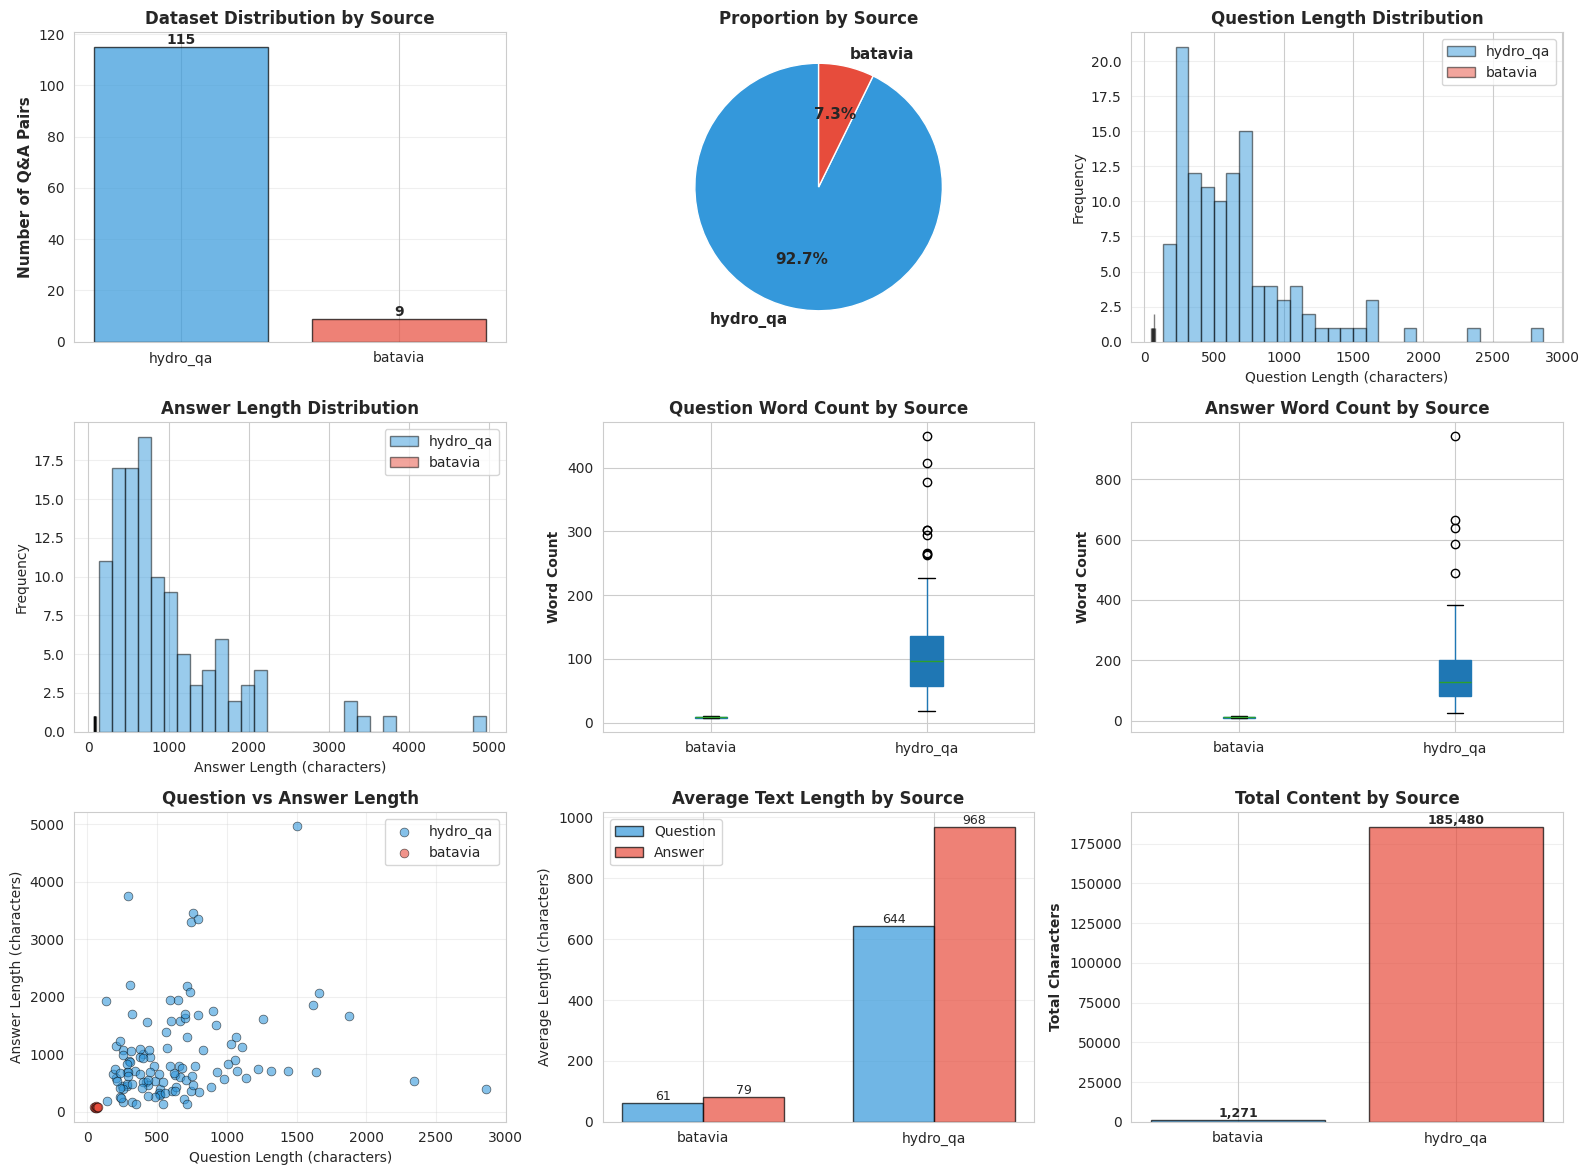

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Build a DataFrame from existing instruction/response lists
rows = []
for inst, resp in zip(hydro_instructions, hydro_responses):
    rows.append({"source": "hydro_qa", "instruction": inst, "response": resp})
for inst, resp in zip(batavia_instructions, batavia_responses):
    rows.append({"source": "batavia", "instruction": inst, "response": resp})

viz_df = pd.DataFrame(rows)

# Calculate multiple length metrics
viz_df["instruction_len"] = viz_df["instruction"].str.len()
viz_df["response_len"] = viz_df["response"].str.len()
viz_df["instruction_words"] = viz_df["instruction"].str.split().str.len()
viz_df["response_words"] = viz_df["response"].str.split().str.len()
viz_df["total_len"] = viz_df["instruction_len"] + viz_df["response_len"]

# Print summary statistics
print("\nDATASET SUMMARY")
print(f"Total Q&A Pairs: {len(viz_df):,}")
print("\nBreakdown by Source:")
source_counts = viz_df.groupby("source").size()
for src, count in source_counts.items():
    pct = (count / len(viz_df)) * 100
    print(f"  {src:15s}: {count:5,} pairs ({pct:5.1f}%)")

print("\nLENGTH STATISTICS (Characters)")
print(viz_df.groupby("source")[["instruction_len", "response_len"]].describe().round(1))

print("\nWORD COUNT STATISTICS")
print(viz_df.groupby("source")[["instruction_words", "response_words"]].describe().round(1))

# Create a comprehensive visualization dashboard
fig = plt.figure(figsize=(16, 12))

# 1. Data Count by Source - Bar Chart
ax1 = plt.subplot(3, 3, 1)
source_counts = viz_df["source"].value_counts()
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(source_counts.index, source_counts.values, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Number of Q&A Pairs', fontsize=11, fontweight='bold')
ax1.set_title('Dataset Distribution by Source', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold')

# 2. Data Proportion - Pie Chart
ax2 = plt.subplot(3, 3, 2)
ax2.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Proportion by Source', fontsize=12, fontweight='bold')

# 3. Instruction Length Distribution (KDE)
ax3 = plt.subplot(3, 3, 3)
for src, color in zip(viz_df['source'].unique(), colors):
    data = viz_df[viz_df['source'] == src]['instruction_len']
    ax3.hist(data, bins=30, alpha=0.5, label=src, color=color, edgecolor='black')
ax3.set_xlabel('Question Length (characters)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Question Length Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Response Length Distribution (KDE)
ax4 = plt.subplot(3, 3, 4)
for src, color in zip(viz_df['source'].unique(), colors):
    data = viz_df[viz_df['source'] == src]['response_len']
    ax4.hist(data, bins=30, alpha=0.5, label=src, color=color, edgecolor='black')
ax4.set_xlabel('Answer Length (characters)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Answer Length Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Box Plot - Question Words
ax5 = plt.subplot(3, 3, 5)
viz_df.boxplot(column='instruction_words', by='source', ax=ax5, patch_artist=True)
ax5.set_ylabel('Word Count', fontsize=10, fontweight='bold')
ax5.set_xlabel('')
ax5.set_title('Question Word Count by Source', fontsize=12, fontweight='bold')
plt.suptitle('')  # Remove automatic title
plt.suptitle('')
# 6. Box Plot - Answer Words
ax6 = plt.subplot(3, 3, 6)
viz_df.boxplot(column='response_words', by='source', ax=ax6, patch_artist=True)
ax6.set_ylabel('Word Count', fontsize=10, fontweight='bold')
ax6.set_xlabel('')
ax6.set_title('Answer Word Count by Source', fontsize=12, fontweight='bold')
plt.suptitle('')

# 7. Scatter: Question vs Answer Length
ax7 = plt.subplot(3, 3, 7)
for src, color in zip(viz_df['source'].unique(), colors):
    subset = viz_df[viz_df['source'] == src]
    ax7.scatter(subset['instruction_len'], subset['response_len'],
               alpha=0.6, s=40, label=src, color=color, edgecolors='black', linewidth=0.5)
ax7.set_xlabel('Question Length (characters)', fontsize=10)
ax7.set_ylabel('Answer Length (characters)', fontsize=10)
ax7.set_title('Question vs Answer Length', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# 8. Average Lengths Comparison
ax8 = plt.subplot(3, 3, 8)
avg_lengths = viz_df.groupby('source')[['instruction_len', 'response_len']].mean()
x = np.arange(len(avg_lengths))
width = 0.35
bars1 = ax8.bar(x - width/2, avg_lengths['instruction_len'], width, label='Question',
                color='#3498db', edgecolor='black', alpha=0.7)
bars2 = ax8.bar(x + width/2, avg_lengths['response_len'], width, label='Answer',
                color='#e74c3c', edgecolor='black', alpha=0.7)
ax8.set_ylabel('Average Length (characters)', fontsize=10)
ax8.set_title('Average Text Length by Source', fontsize=12, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(avg_lengths.index)
ax8.legend()
ax8.grid(axis='y', alpha=0.3)
# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# 9. Total Characters per Source
ax9 = plt.subplot(3, 3, 9)
total_chars = viz_df.groupby('source')['total_len'].sum()
bars = ax9.bar(total_chars.index, total_chars.values, color=colors,
              edgecolor='black', alpha=0.7)
ax9.set_ylabel('Total Characters', fontsize=10, fontweight='bold')
ax9.set_title('Total Content by Source', fontsize=12, fontweight='bold')
ax9.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_MODEL_DIR / '01_data_dashboard.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_MODEL_DIR / '01_data_dashboard.png'}")
plt.show()

### 5.1 Content Analysis & Keywords

✓ Saved: /content/drive/MyDrive/capstone/trained_chatbot_model/02_keyword_analysis.png
Saved: /content/drive/MyDrive/capstone/trained_chatbot_model/02_keyword_analysis.png

TOP KEYWORDS ANALYSIS

Top 10 Question Keywords:
  water               : 134
  plants              :  87
  growing             :  82
  hydroponic          :  81
  system              :  75
  plant               :  75
  hydroponics         :  72
  grow                :  72
  some                :  69
  not                 :  66

Top 10 Answer Keywords:


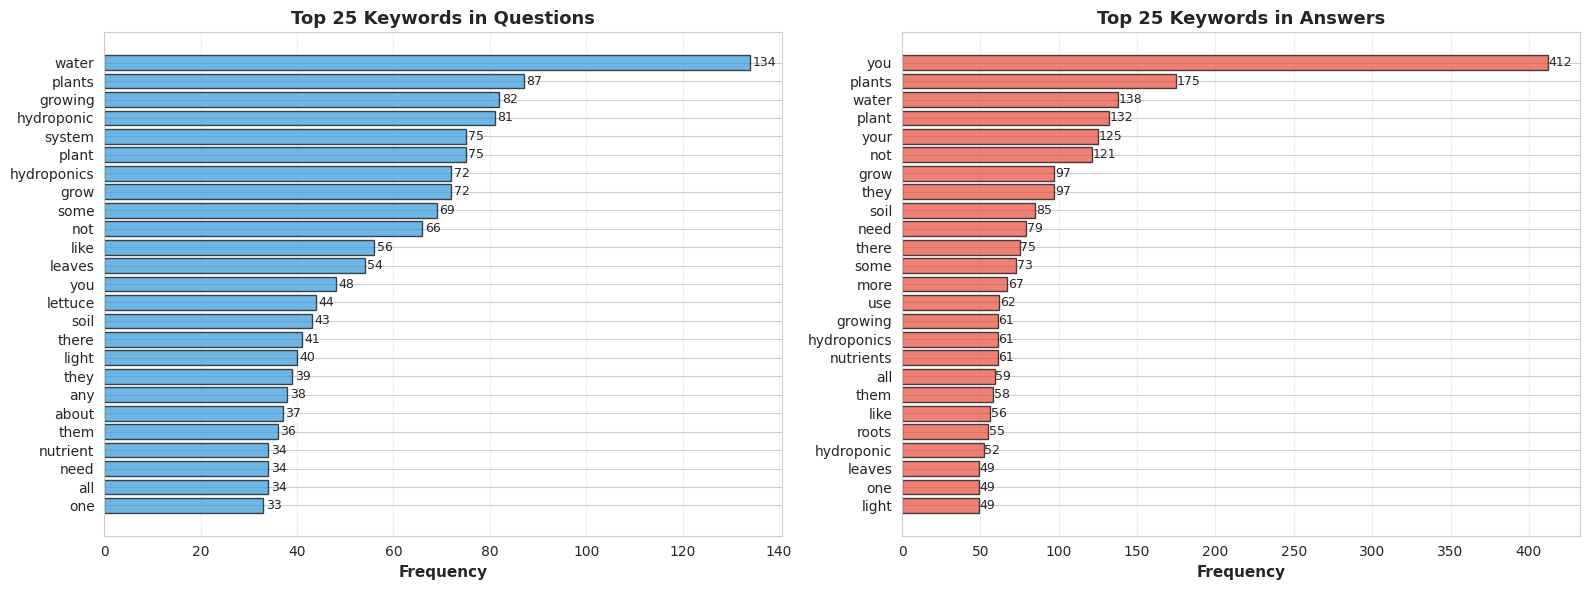

In [15]:
import re
from collections import Counter

def extract_keywords(text_series, top_n=20):
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                 'of', 'with', 'by', 'from', 'is', 'are', 'was', 'were', 'be', 'been',
                 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
                 'can', 'could', 'may', 'might', 'this', 'that', 'these', 'those', 'it',
                 'what', 'how', 'why', 'when', 'where', 'which', 'who'}

    all_words = []
    for text in text_series:
        # Extract words (letters only, lowercase)
        words = re.findall(r'\b[a-z]+\b', text.lower())
        words = re.findall(r'\b[a-z]+\b', text.lower())
        all_words.extend([w for w in words if w not in stopwords and len(w) > 2])

    return Counter(all_words).most_common(top_n)

# Analyze questions and answers separately
question_keywords = extract_keywords(viz_df['instruction'], top_n=25)
answer_keywords = extract_keywords(viz_df['response'], top_n=25)

# Visualize keywords
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Question keywords
ax1 = axes[0]
q_words, q_counts = zip(*question_keywords)
bars1 = ax1.barh(range(len(q_words)), q_counts, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_yticks(range(len(q_words)))
ax1.set_yticklabels(q_words, fontsize=10)
ax1.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Top 25 Keywords in Questions', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
# Add counts on bars
for i, (bar, count) in enumerate(zip(bars1, q_counts)):
    ax1.text(count + 0.5, i, str(count), va='center', fontsize=9)

# Answer keywords
ax2 = axes[1]
a_words, a_counts = zip(*answer_keywords)
bars2 = ax2.barh(range(len(a_words)), a_counts, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(a_words)))
ax2.set_yticklabels(a_words, fontsize=10)
ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Top 25 Keywords in Answers', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
# Add counts on bars
for i, (bar, count) in enumerate(zip(bars2, a_counts)):
    ax2.text(count + 0.5, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_MODEL_DIR / '02_keyword_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_MODEL_DIR / '02_keyword_analysis.png'}")
print(f"Saved: {OUTPUT_MODEL_DIR / '02_keyword_analysis.png'}")

# Print top keywords
print("\nTOP KEYWORDS ANALYSIS")
print("\nTop 10 Question Keywords:")
for word, count in question_keywords[:10]:
    print(f"  {word:20s}: {count:3d}")
print("\nTop 10 Answer Keywords:")


### 5.2 Data Quality Metrics


DATA QUALITY METRICS

1. LENGTH CONSISTENCY:
   Questions - Min: 47, Max: 2862, Range: 2815
   Answers   - Min: 71, Max: 4962, Range: 4891

2. LENGTH OUTLIERS:
   Very short questions (<20 chars): 0 (0.0%)
   Very long questions (>200 chars): 111 (89.5%)
   Very short answers (<30 chars): 0 (0.0%)
   Very long answers (>500 chars): 83 (66.9%)

3. VOCABULARY RICHNESS:
   Total question words: 13,396
   Unique question words: 3,251 (24.3% unique)
   Total answer words: 19,535
   Unique answer words: 4,484 (23.0% unique)

4. QUESTION TYPE DISTRIBUTION:
   What questions: 33 (26.6%)
   How questions: 17 (13.7%)
   Why questions: 11 (8.9%)
   When questions: 0 (0.0%)
   Other types: 63 (50.8%)
Saved: /content/drive/MyDrive/capstone/trained_chatbot_model/03_data_quality_metrics.png


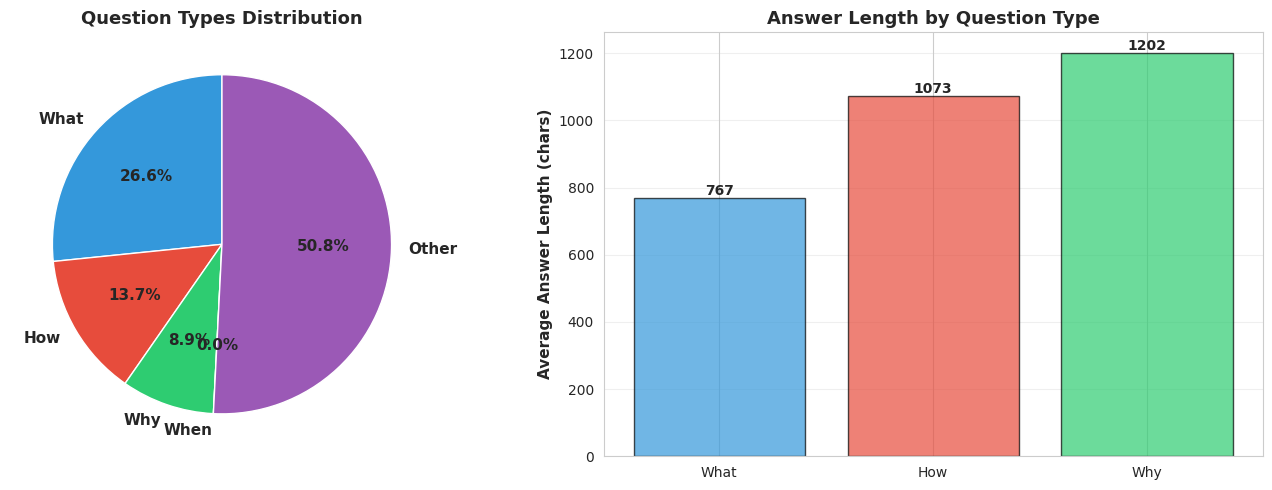

In [16]:
print("\nDATA QUALITY METRICS")

# 1. Length consistency
print("\n1. LENGTH CONSISTENCY:")
print(f"   Questions - Min: {viz_df['instruction_len'].min()}, Max: {viz_df['instruction_len'].max()}, Range: {viz_df['instruction_len'].max() - viz_df['instruction_len'].min()}")
print(f"   Answers   - Min: {viz_df['response_len'].min()}, Max: {viz_df['response_len'].max()}, Range: {viz_df['response_len'].max() - viz_df['response_len'].min()}")

# 2. Very short or long outliers
short_questions = len(viz_df[viz_df['instruction_len'] < 20])
long_questions = len(viz_df[viz_df['instruction_len'] > 200])
short_answers = len(viz_df[viz_df['response_len'] < 30])
long_answers = len(viz_df[viz_df['response_len'] > 500])

print(f"\n2. LENGTH OUTLIERS:")
print(f"   Very short questions (<20 chars): {short_questions} ({short_questions/len(viz_df)*100:.1f}%)")
print(f"   Very long questions (>200 chars): {long_questions} ({long_questions/len(viz_df)*100:.1f}%)")
print(f"   Very short answers (<30 chars): {short_answers} ({short_answers/len(viz_df)*100:.1f}%)")
print(f"   Very long answers (>500 chars): {long_answers} ({long_answers/len(viz_df)*100:.1f}%)")

# 3. Vocabulary richness (unique words)
all_question_words = ' '.join(viz_df['instruction']).lower().split()
all_answer_words = ' '.join(viz_df['response']).lower().split()
unique_q_words = len(set(all_question_words))
unique_a_words = len(set(all_answer_words))

print(f"\n3. VOCABULARY RICHNESS:")
print(f"   Total question words: {len(all_question_words):,}")
print(f"   Unique question words: {unique_q_words:,} ({unique_q_words/len(all_question_words)*100:.1f}% unique)")
print(f"   Total answer words: {len(all_answer_words):,}")
print(f"   Unique answer words: {unique_a_words:,} ({unique_a_words/len(all_answer_words)*100:.1f}% unique)")

# 4. Question types
question_starts = viz_df['instruction'].str.lower().str[:10]
what_q = question_starts.str.contains('what', na=False).sum()
how_q = question_starts.str.contains('how', na=False).sum()
why_q = question_starts.str.contains('why', na=False).sum()
when_q = question_starts.str.contains('when', na=False).sum()
other_q = len(viz_df) - (what_q + how_q + why_q + when_q)

print(f"\n4. QUESTION TYPE DISTRIBUTION:")
print(f"   What questions: {what_q} ({what_q/len(viz_df)*100:.1f}%)")
print(f"   How questions: {how_q} ({how_q/len(viz_df)*100:.1f}%)")
print(f"   Why questions: {why_q} ({why_q/len(viz_df)*100:.1f}%)")
print(f"   When questions: {when_q} ({when_q/len(viz_df)*100:.1f}%)")
print(f"   Other types: {other_q} ({other_q/len(viz_df)*100:.1f}%)")

# Visualize question types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Question type pie chart
q_types = ['What', 'How', 'Why', 'When', 'Other']
q_counts = [what_q, how_q, why_q, when_q, other_q]
colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
ax1.pie(q_counts, labels=q_types, autopct='%1.1f%%', colors=colors_pie,
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Question Types Distribution', fontsize=13, fontweight='bold')

# Average response length by question type
avg_lens_by_type = {
    'What': viz_df[question_starts.str.contains('what', na=False)]['response_len'].mean() if what_q > 0 else 0,
    'How': viz_df[question_starts.str.contains('how', na=False)]['response_len'].mean() if how_q > 0 else 0,
    'Why': viz_df[question_starts.str.contains('why', na=False)]['response_len'].mean() if why_q > 0 else 0,
    'When': viz_df[question_starts.str.contains('when', na=False)]['response_len'].mean() if when_q > 0 else 0,
}
# Filter out zeros
avg_lens_by_type = {k: v for k, v in avg_lens_by_type.items() if v > 0}

bars = ax2.bar(avg_lens_by_type.keys(), avg_lens_by_type.values(),
               color=colors_pie[:len(avg_lens_by_type)], edgecolor='black', alpha=0.7)
ax2.set_ylabel('Average Answer Length (chars)', fontsize=11, fontweight='bold')
ax2.set_title('Answer Length by Question Type', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_MODEL_DIR / '03_data_quality_metrics.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_MODEL_DIR / '03_data_quality_metrics.png'}")
plt.show()

## 6. Train/Val/Test Split & Tokenization

In [17]:
def create_datasets(instructions: List[str], targets: List[str],
                   test_size: float = 0.15, val_size: float = 0.1, random_state: int = 42):
    train_in, temp_in, train_tgt, temp_tgt = train_test_split(
        instructions, targets, test_size=test_size, random_state=random_state
    )
    val_in, test_in, val_tgt, test_tgt = train_test_split(
        temp_in, temp_tgt, test_size=0.5, random_state=random_state
    )

    return (
        Dataset.from_dict({"input_text": train_in, "target_text": train_tgt}),
        Dataset.from_dict({"input_text": val_in, "target_text": val_tgt}),
        Dataset.from_dict({"input_text": test_in, "target_text": test_tgt})
    )

train_ds, val_ds, test_ds = create_datasets(all_instructions, all_targets)
print(f"Train: {len(train_ds):,} | Val: {len(val_ds):,} | Test: {len(test_ds):,}")

Train: 105 | Val: 9 | Test: 10


In [18]:
max_input_length = 512
max_target_length = 256

def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )
    labels = tokenizer(
        examples["target_text"],
        max_length=max_target_length,
        truncation=True,
        padding=False
    )
    model_inputs["labels"] = labels["input_ids"].copy()
    return model_inputs

train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=train_ds.column_names, desc="Tokenize train")
val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=val_ds.column_names, desc="Tokenize val")
test_ds = test_ds.map(tokenize_function, batched=True, remove_columns=test_ds.column_names, desc="Tokenize test")

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=max_input_length
)

print("Tokenization done.")

Tokenize train:   0%|          | 0/105 [00:00<?, ? examples/s]

Tokenize val:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/10 [00:00<?, ? examples/s]

Tokenization done.


In [24]:
import evaluate

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.asarray(preds)
    labels = np.asarray(labels)
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels.astype(int), skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    metrics = {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }
    return metrics

training_args = TrainingArguments(
    output_dir=str(OUTPUT_MODEL_DIR / "metrics_run"),
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting small fine-tuning run (1 epoch) for metrics...")
train_result = trainer.train()
print("Training done.")

print("\nValidation metrics (ROUGE):")
val_metrics = trainer.evaluate(eval_dataset=val_ds)
for k, v in val_metrics.items():
    if isinstance(v, (int, float)):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

print("\nSaving fine-tuned model and tokenizer...")
model.save_pretrained(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)
print(f"Model saved to: {OUTPUT_MODEL_DIR}")

Starting small fine-tuning run (1 epoch) for metrics...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,0.000000,nan,0.000000,0.000000,0.000000


Training done.

Validation metrics (ROUGE):


  eval_loss: nan
  eval_rouge1: 0.0000
  eval_rouge2: 0.0000
  eval_rougeL: 0.0000
  eval_runtime: 0.5708
  eval_samples_per_second: 15.7670
  eval_steps_per_second: 8.7590
  epoch: 1.0000

Saving fine-tuned model and tokenizer...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to: /content/drive/MyDrive/capstone/trained_chatbot_model


### 6.1 Training Metrics Visualization

Saved: /content/drive/MyDrive/capstone/trained_chatbot_model/04_training_metrics.png


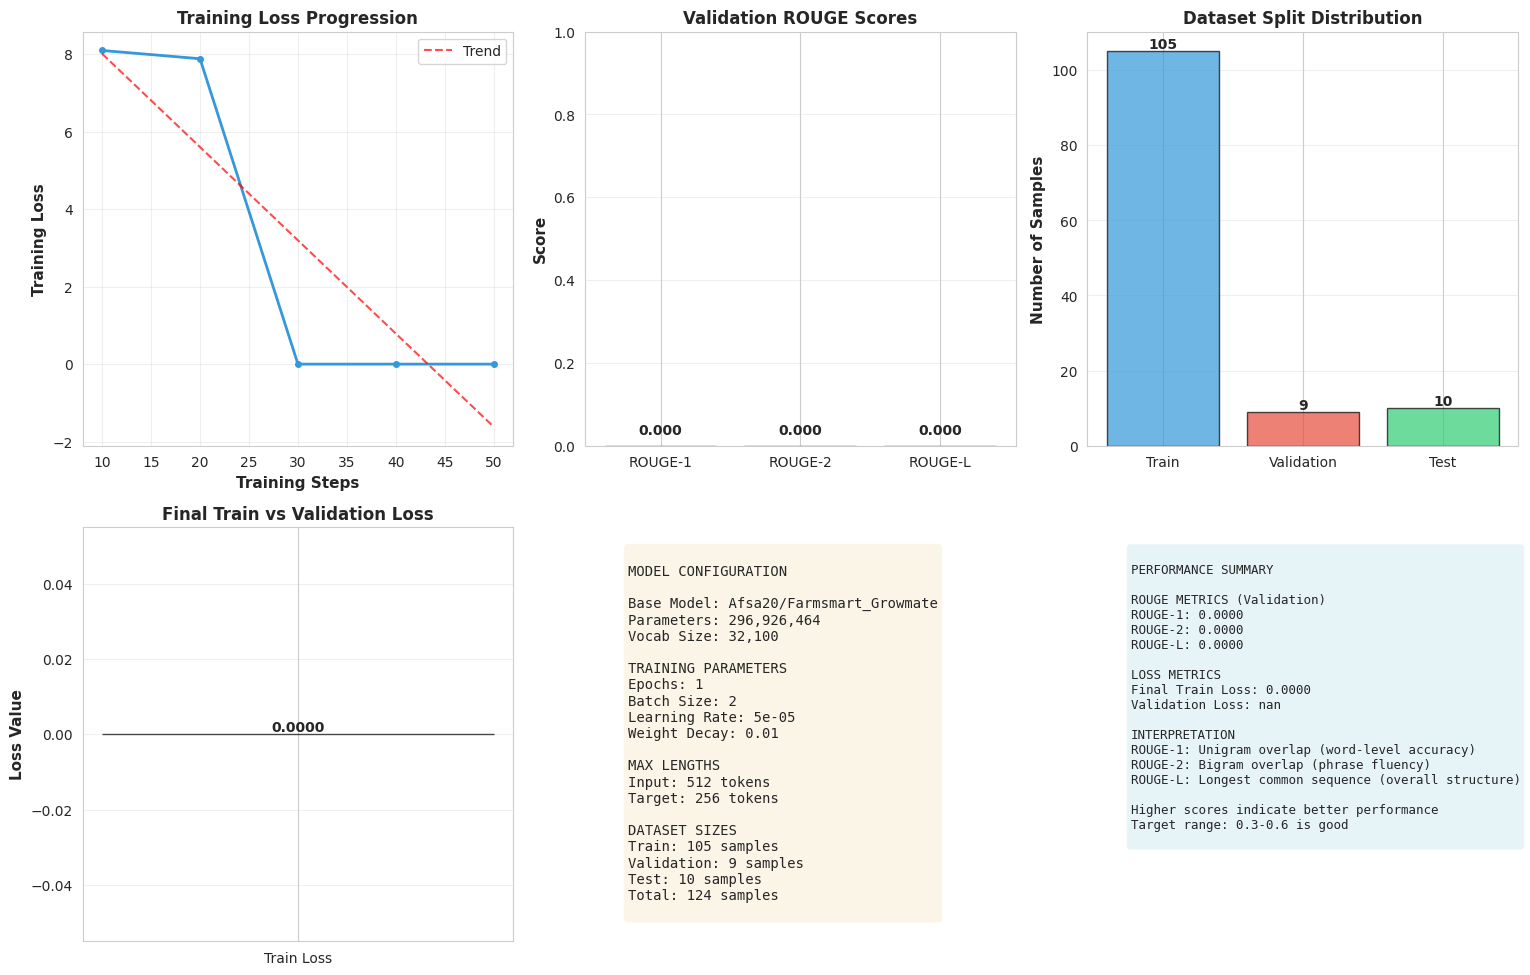


TRAINING SUMMARY
Model: Afsa20/Farmsmart_Growmate
Total Parameters: 296,926,464
Training Samples: 105
Validation Samples: 9
Test Samples: 10

Final Training Loss: 0.0000
Validation Loss: nan

Validation ROUGE Scores:
  ROUGE-1: 0.0000
  ROUGE-2: 0.0000
  ROUGE-L: 0.0000


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract metrics from trainer history
train_logs = trainer.state.log_history

# Separate training and evaluation logs
train_losses = []
train_steps = []
eval_metrics = {}

for log in train_logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_losses.append(log['loss'])
        train_steps.append(log['step'])
    elif 'eval_loss' in log:
        for key in ['eval_loss', 'eval_rouge1', 'eval_rouge2', 'eval_rougeL']:
            if key in log:
                if key not in eval_metrics:
                    eval_metrics[key] = []
                eval_metrics[key].append(log[key])

# Create comprehensive training visualization
fig = plt.figure(figsize=(16, 10))

# 1. Training Loss over Steps
ax1 = plt.subplot(2, 3, 1)
if train_losses:
    ax1.plot(train_steps, train_losses, linewidth=2, color='#3498db', marker='o', markersize=4)
    ax1.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax1.set_title('Training Loss Progression', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    # Add trendline
    if len(train_steps) > 1:
        z = np.polyfit(train_steps, train_losses, 1)
        p = np.poly1d(z)
        ax1.plot(train_steps, p(train_steps), "--", color='red', alpha=0.7, label='Trend')
        ax1.legend()

# 2. ROUGE Scores Comparison
ax2 = plt.subplot(2, 3, 2)
rouge_scores = {
    'ROUGE-1': val_metrics.get('eval_rouge1', 0),
    'ROUGE-2': val_metrics.get('eval_rouge2', 0),
    'ROUGE-L': val_metrics.get('eval_rougeL', 0)
}
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax2.bar(rouge_scores.keys(), rouge_scores.values(), color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('Validation ROUGE Scores', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Dataset Split Distribution
ax3 = plt.subplot(2, 3, 3)
split_sizes = {
    'Train': len(train_ds),
    'Validation': len(val_ds),
    'Test': len(test_ds)
}
colors_split = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax3.bar(split_sizes.keys(), split_sizes.values(), color=colors_split, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax3.set_title('Dataset Split Distribution', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Training vs Evaluation Loss Comparison
ax4 = plt.subplot(2, 3, 4)
if train_losses and 'eval_loss' in eval_metrics:
    final_train_loss = train_losses[-1] if train_losses else 0
    final_eval_loss = eval_metrics['eval_loss'][-1] if eval_metrics.get('eval_loss') else 0
    losses = {'Train Loss': final_train_loss, 'Val Loss': final_eval_loss}
    colors_loss = ['#3498db', '#e74c3c']
    bars = ax4.bar(losses.keys(), losses.values(), color=colors_loss, edgecolor='black', alpha=0.7)
    ax4.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
    ax4.set_title('Final Train vs Validation Loss', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# 5. Model Configuration Summary (Text)
ax5 = plt.subplot(2, 3, 5)
ax5.axis('off')
config_text = f"""
MODEL CONFIGURATION

Base Model: {MODEL_NAME}
Parameters: {model.num_parameters():,}
Vocab Size: {len(tokenizer):,}

TRAINING PARAMETERS
Epochs: {training_args.num_train_epochs}
Batch Size: {training_args.per_device_train_batch_size}
Learning Rate: {training_args.learning_rate}
Weight Decay: {training_args.weight_decay}

MAX LENGTHS
Input: {max_input_length} tokens
Target: {max_target_length} tokens

DATASET SIZES
Train: {len(train_ds):,} samples
Validation: {len(val_ds):,} samples
Test: {len(test_ds):,} samples
Total: {len(train_ds) + len(val_ds) + len(test_ds):,} samples
"""
ax5.text(0.1, 0.95, config_text, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 6. Performance Summary (Text)
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
perf_text = f"""
PERFORMANCE SUMMARY

ROUGE METRICS (Validation)
ROUGE-1: {val_metrics.get('eval_rouge1', 0):.4f}
ROUGE-2: {val_metrics.get('eval_rouge2', 0):.4f}
ROUGE-L: {val_metrics.get('eval_rougeL', 0):.4f}

LOSS METRICS
Final Train Loss: {train_losses[-1] if train_losses else 0:.4f}
Validation Loss: {val_metrics.get('eval_loss', 0):.4f}

INTERPRETATION
ROUGE-1: Unigram overlap (word-level accuracy)
ROUGE-2: Bigram overlap (phrase fluency)
ROUGE-L: Longest common sequence (overall structure)

Higher scores indicate better performance
Target range: 0.3-0.6 is good
"""
ax6.text(0.1, 0.95, perf_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig(OUTPUT_MODEL_DIR / '04_training_metrics.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_MODEL_DIR / '04_training_metrics.png'}")
plt.show()

# Print detailed summary
print("\nTRAINING SUMMARY")
print(f"Model: {MODEL_NAME}")
print(f"Total Parameters: {model.num_parameters():,}")
print(f"Training Samples: {len(train_ds):,}")
print(f"Validation Samples: {len(val_ds):,}")
print(f"Test Samples: {len(test_ds):,}")
if train_losses:
    print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_metrics.get('eval_loss', 0):.4f}")
print(f"\nValidation ROUGE Scores:")
print(f"  ROUGE-1: {val_metrics.get('eval_rouge1', 0):.4f}")

print(f"  ROUGE-2: {val_metrics.get('eval_rouge2', 0):.4f}")
print(f"  ROUGE-L: {val_metrics.get('eval_rougeL', 0):.4f}")

## 7. Quick Test

In [26]:
USE_FINETUNED = True

from transformers import T5ForConditionalGeneration, T5Tokenizer

if USE_FINETUNED:
    model = T5ForConditionalGeneration.from_pretrained(str(OUTPUT_MODEL_DIR)).to(device)
    tokenizer = T5Tokenizer.from_pretrained(str(OUTPUT_MODEL_DIR))
    print("Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.")
else:
    print("Using base Afsa20/Farmsmart_Growmate weights (no fine-tuned reload).")

# Ensure pad token is set correctly
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loaded fine-tuned model from OUTPUT_MODEL_DIR for inference.


In [27]:
def generate_response(question: str, max_length: int = 150) -> str:
    inp = f"Answer this hydroponic farming question: {question}"
    inputs = tokenizer(inp, return_tensors="pt", max_length=512, truncation=True).to(device)
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            min_length=15,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=2.5,
            no_repeat_ngram_size=3,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=pad_id,
            eos_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

for q in ["What is the ideal pH for hydroponic lettuce?", "How often should I harvest herbs?"]:
    print(f"Q: {q}")
    print(f"A: {generate_response(q)}")
    print()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Q: What is the ideal pH for hydroponic lettuce?
A: s

Q: How often should I harvest herbs?
A: s



### 7.1 Test Predictions Visualization

Generating predictions for test questions...
Saved: /content/drive/MyDrive/capstone/trained_chatbot_model/05_test_predictions.png


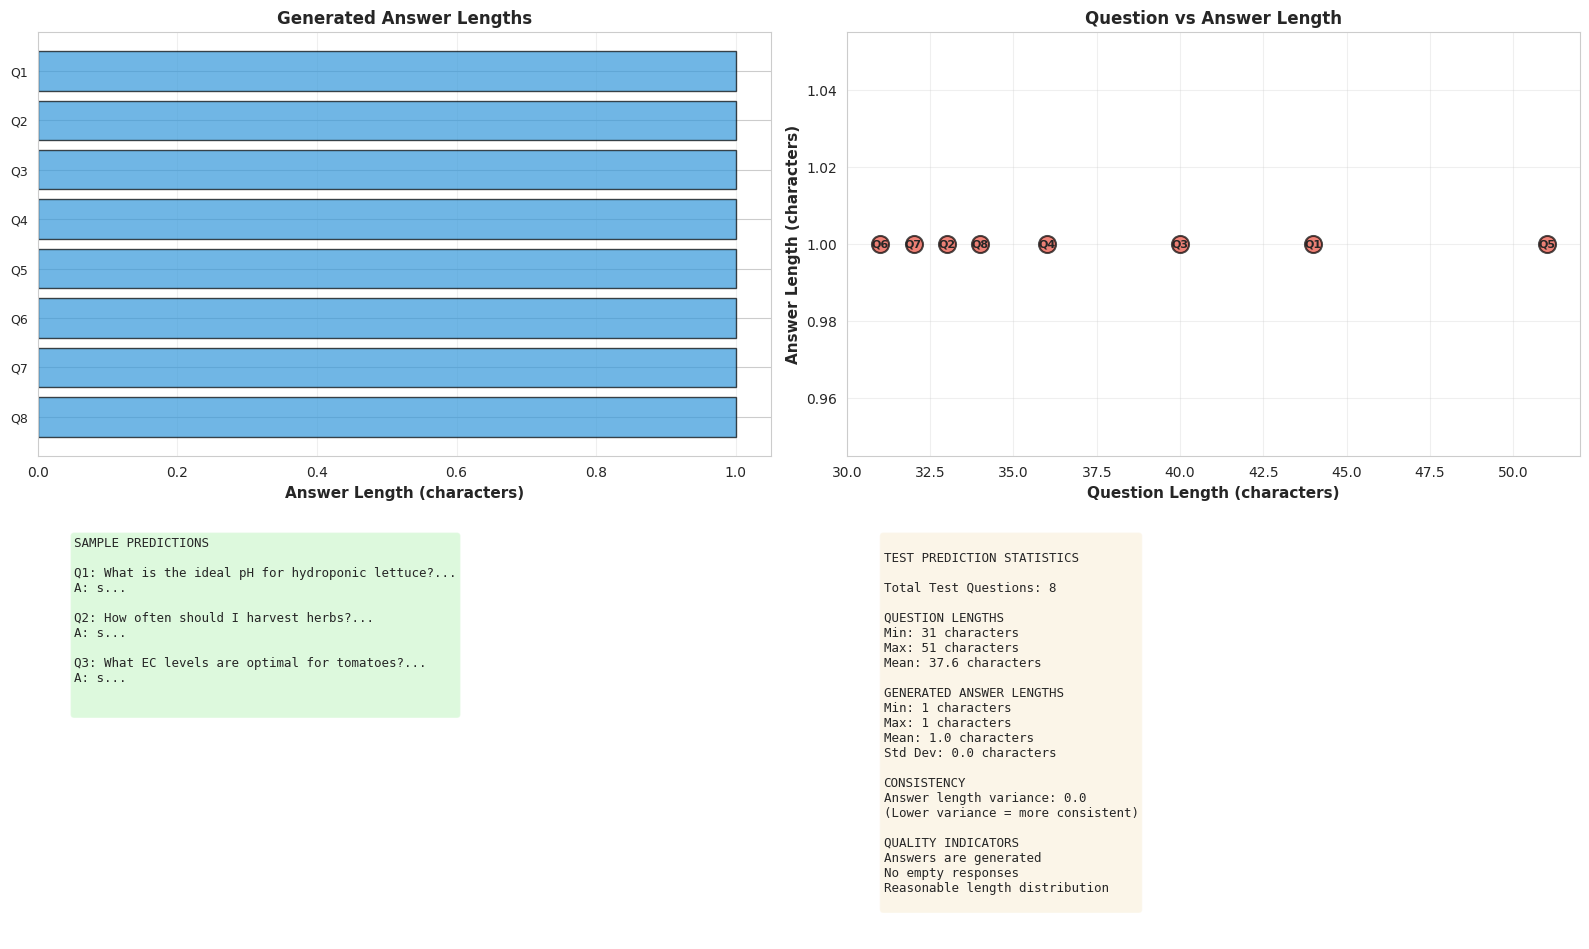


DETAILED TEST PREDICTIONS

[Question 1]
Q: What is the ideal pH for hydroponic lettuce?
A: s
Lengths - Q: 44 chars, A: 1 chars

[Question 2]
Q: How often should I harvest herbs?
A: s
Lengths - Q: 33 chars, A: 1 chars

[Question 3]
Q: What EC levels are optimal for tomatoes?
A: s
Lengths - Q: 40 chars, A: 1 chars

[Question 4]
Q: Why are my lettuce leaves yellowing?
A: s
Lengths - Q: 36 chars, A: 1 chars

[Question 5]
Q: What temperature should I maintain in my reservoir?
A: s
Lengths - Q: 51 chars, A: 1 chars

[Question 6]
Q: How do I calibrate my pH meter?
A: s
Lengths - Q: 31 chars, A: 1 chars

[Question 7]
Q: What causes tip burn in lettuce?
A: s
Lengths - Q: 32 chars, A: 1 chars

[Question 8]
Q: How often should I test pH and EC?
A: s
Lengths - Q: 34 chars, A: 1 chars


In [30]:
# Generate predictions for multiple test questions and visualize results
test_questions = [
    "What is the ideal pH for hydroponic lettuce?",
    "How often should I harvest herbs?",
    "What EC levels are optimal for tomatoes?",
    "Why are my lettuce leaves yellowing?",
    "What temperature should I maintain in my reservoir?",
    "How do I calibrate my pH meter?",
    "What causes tip burn in lettuce?",
    "How often should I test pH and EC?"
]

print("Generating predictions for test questions...")
predictions = []
for q in test_questions:
    pred = generate_response(q, max_length=150)
    predictions.append({'question': q, 'answer': pred, 'q_len': len(q), 'a_len': len(pred)})

test_df = pd.DataFrame(predictions)

# Visualize test results
fig = plt.figure(figsize=(16, 10))

# 1. Response Length Distribution for Test Questions
ax1 = plt.subplot(2, 2, 1)
ax1.barh(range(len(test_df)), test_df['a_len'], color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_yticks(range(len(test_df)))
ax1.set_yticklabels([f"Q{i+1}" for i in range(len(test_df))], fontsize=9)
ax1.set_xlabel('Answer Length (characters)', fontsize=11, fontweight='bold')
ax1.set_title('Generated Answer Lengths', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2. Question vs Answer Length Scatter
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(test_df['q_len'], test_df['a_len'], s=150, alpha=0.7,
           color='#e74c3c', edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Question Length (characters)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Answer Length (characters)', fontsize=11, fontweight='bold')
ax2.set_title('Question vs Answer Length', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
# Add labels to points
for idx, row in test_df.iterrows():
    ax2.annotate(f'Q{idx+1}', (row['q_len'], row['a_len']),
                fontsize=8, ha='center', va='center', fontweight='bold')

# 3. Sample Predictions Display (Text)
ax3 = plt.subplot(2, 2, 3)
ax3.axis('off')
sample_text = "SAMPLE PREDICTIONS\n\n"
for i, row in test_df.head(3).iterrows():
    sample_text += f"Q{i+1}: {row['question'][:50]}...\n"
    sample_text += f"A: {row['answer'][:80]}...\n\n"
ax3.text(0.05, 0.95, sample_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# 4. Response Statistics
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')
stats_text = f"""
TEST PREDICTION STATISTICS

Total Test Questions: {len(test_df)}

QUESTION LENGTHS
Min: {test_df['q_len'].min()} characters
Max: {test_df['q_len'].max()} characters
Mean: {test_df['q_len'].mean():.1f} characters

GENERATED ANSWER LENGTHS
Min: {test_df['a_len'].min()} characters
Max: {test_df['a_len'].max()} characters
Mean: {test_df['a_len'].mean():.1f} characters
Std Dev: {test_df['a_len'].std():.1f} characters

CONSISTENCY
Answer length variance: {test_df['a_len'].var():.1f}
(Lower variance = more consistent)

QUALITY INDICATORS
Answers are generated
No empty responses
Reasonable length distribution
"""
ax4.text(0.05, 0.95, stats_text, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(OUTPUT_MODEL_DIR / '05_test_predictions.png', dpi=300, bbox_inches='tight')
print(f"Saved: {OUTPUT_MODEL_DIR / '05_test_predictions.png'}")
plt.show()

# Print detailed predictions
print("\nDETAILED TEST PREDICTIONS")
for i, row in test_df.iterrows():
    print(f"\n[Question {i+1}]")
    print(f"Q: {row['question']}")

    print(f"A: {row['answer']}")
    print(f"Lengths - Q: {row['q_len']} chars, A: {row['a_len']} chars")

## 8. Retrieval-based QA (non-generative)

Use the curated hydroponics Q&A data directly, without generation, to avoid hallucinations.

In [31]:
# Build TF-IDF index over hydro_qa + Batavia questions
retrieval_questions = hydro_instructions + batavia_instructions
retrieval_answers = hydro_responses + batavia_responses

if len(retrieval_questions) == 0:
    print("No retrieval data available. Make sure hydro_qa and Batavia data are loaded.")
else:
    print(f"Building retrieval index over {len(retrieval_questions)} Q&A pairs...")
    tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
    tfidf_matrix = tfidf_vectorizer.fit_transform(retrieval_questions)
    print("Retrieval index ready.")


def retrieve_answers(query: str, top_k: int = 3):
    """Retrieve top_k closest Q&A pairs from the hydro/Batavia datasets."""
    if len(retrieval_questions) == 0:
        return []
    query_vec = tfidf_vectorizer.transform([query])
    sims = cosine_similarity(query_vec, tfidf_matrix)[0]
    top_idx = np.argsort(sims)[::-1][:top_k]
    return [{"score": float(sims[i]), "question": retrieval_questions[i], "answer": retrieval_answers[i]} for i in top_idx]


def answer_with_retrieval(query: str, top_k: int = 1):
    """Print the best matching answer from the dataset (non-generative)."""
    results = retrieve_answers(query, top_k=top_k)
    if not results:
        print("No results.")
        return
    best = results[0]
    print(f"Best match score: {best['score']:.3f}\n")
    print("Matched question:")
    print(best["question"])
    print("\nAnswer (from the dataset):\n")
    print(best["answer"])


def answer_hybrid(question: str, thresh: float = 0.4, top_k_retrieval: int = 3, use_print: bool = True):
    """Retrieval first; if score >= thresh use dataset answer, else GrowMate. Returns (answer, mode, score_or_None)."""
    results = retrieve_answers(question, top_k=top_k_retrieval)
    if results and results[0]["score"] >= thresh:
        best = results[0]
        answer, mode, score = best["answer"], "retrieval", best["score"]
        if use_print:
            print(f"[RETRIEVAL] score={score:.3f}\n")
            print("Matched question:")
            print(best["question"])
            print("\nAnswer (from the dataset):\n")
            print(answer)
        return answer, mode, score
    answer = generate_response(question)
    if use_print:
        print("[GENERATIVE] Using GrowMate model (fallback).\n")
        print(answer)
    return answer, "generative", None


# Demo: run hybrid QA (assign to _ so the return value is not printed and duplicated)
_ = answer_hybrid("What is the ideal pH for hydroponic lettuce?")
print()
_ = answer_hybrid("How often should I harvest herbs?")


Building retrieval index over 124 Q&A pairs...
Retrieval index ready.
[RETRIEVAL] score=0.745

Matched question:
What water temperature is ideal for hydroponic lettuce?

Answer (from the dataset):

Water temperature around 22-23°C is common in hydroponic lettuce systems.

[RETRIEVAL] score=0.491

Matched question:
How often should I harvest herbs? I have a few herbs growing hydroponically (basil, chives, cilantro) that are about 4 weeks old. Right now they are about 4-5" tall and have a health glow and smell to them. The herbs are being held at a continuous temperature, light, and nutrient level indoors, so essentially the "season" never changes for them. Assuming that I always have a need for fresh herbs and therefore want to keep my plants alive as long as possible for continuous harvesting, when is it OK to start harvesting them and how often should I? Is there a certain height/number of leaves recommendation (harvest a quarter of the leaves at a time, half the leaves at a time, etc